## ERA Session7 Assignment: Model2
### Target
 - Reduce the number of parameters
 - Maintain decent accuracy from last iteration of Model1
 - Use a transition block to reduce the channel count
 - Keep kernel numbers under 32 so as to reduce the number of paramters

### Results
 - No. of Params: 17,360
 - Best Test Accuracy: 99.05%
 - Best Train Accuracy: 99.50%

### Analysis
 - Number of parametrs reduced from ~75k to 17360
 - Accuracy is still maintained at 99+
 - There is a very little dip in both train and test accuracy
 - Reducing the number of kernels helped to reduce number of parameters
 - Adding a transition block allowed to reduce the kernel numbers thereby reducing the number of paramters


In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from models import Model2 as Model

In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                    #    transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 16, 24, 24]             512
         MaxPool2d-6           [-1, 16, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           2,304
              ReLU-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        MaxPool2d-11             [-1, 16, 5, 5]               0
           Conv2d-12             [-1, 32, 3, 3]           4,608
             ReLU-13             [-1, 32, 3, 3]               0
           Conv2d-14             [-1, 1

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.15199065208435059 Batch_id=468 Accuracy=71.69: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0972, Accuracy: 9693/10000 (96.93%)

EPOCH: 2


Loss=0.06152300164103508 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0595, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Loss=0.010957170277833939 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0459, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.07125484198331833 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0429, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.019328908994793892 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.0476, Accuracy: 9835/10000 (98.35%)

EPOCH: 6


Loss=0.01272827759385109 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0428, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.004500937648117542 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0353, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.006833053659647703 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0342, Accuracy: 9887/10000 (98.87%)

EPOCH: 9


Loss=0.04961735010147095 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0366, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.022623205557465553 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0355, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Loss=0.00104694499168545 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0317, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.007108491379767656 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0351, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.005515884608030319 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.0028959515038877726 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.002632889663800597 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0341, Accuracy: 9901/10000 (99.01%)



Text(0.5, 1.0, 'Test Accuracy')

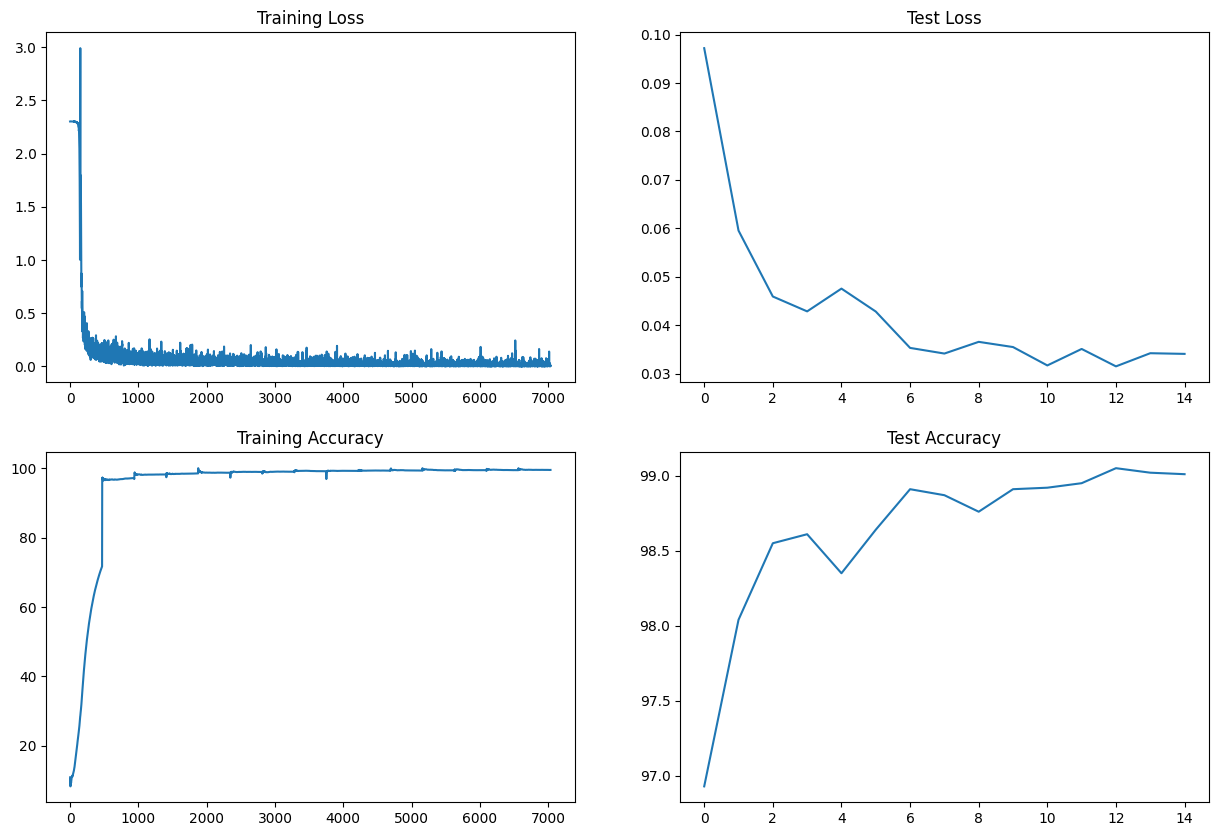

In [18]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")